In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_train='dataset/train'
data_test='dataset/test'
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 4 classes.
Using 1800 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 688 files belonging to 4 classes.
Using 137 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['crack', 'dot', 'good', 'joint']


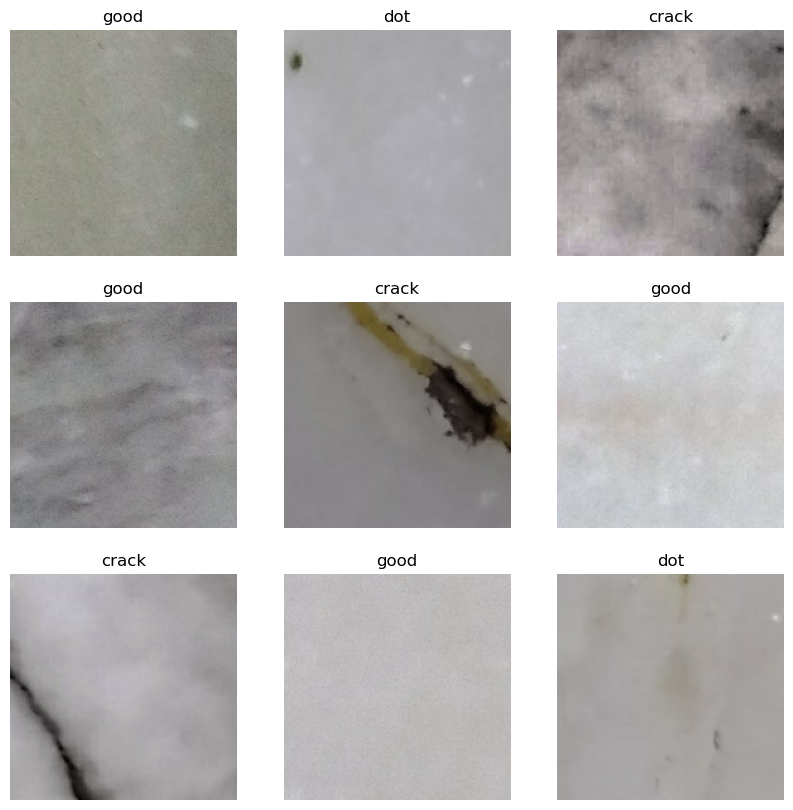

In [6]:
 os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.051960997 1.0


In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 30s 501ms/step - loss: 1.1613 - accuracy: 0.4594 - val_loss: 1.0888 - val_accuracy: 0.3650
Epoch 2/20
57/57 [==============================] - 26s 452ms/step - loss: 1.0191 - accuracy: 0.5800 - val_loss: 0.8244 - val_accuracy: 0.6934
Epoch 3/20
57/57 [==============================] - 30s 512ms/step - loss: 0.8227 - accuracy: 0.7100 - val_loss: 0.6542 - val_accuracy: 0.7810
Epoch 4/20
57/57 [==============================] - 28s 478ms/step - loss: 0.6667 - accuracy: 0.7672 - val_loss: 0.5965 - val_accuracy: 0.7883
Epoch 5/20
57/57 [==============================] - 27s 476ms/step - loss: 0.6542 - accuracy: 0.7622 - val_loss: 0.8909 - val_accuracy: 0.7080
Epoch 6/20
57/57 [==============================] - 31s 539ms/step - loss: 0.6199 - accuracy: 0.7744 - val_loss: 0.5996 - val_accuracy: 0.7956
Epoch 7/20
57/57 [==============================] - 28s 492ms/step - loss: 0.4435 - accuracy: 0.8494 - val_loss: 0.5548 - val_accuracy: 0.8394

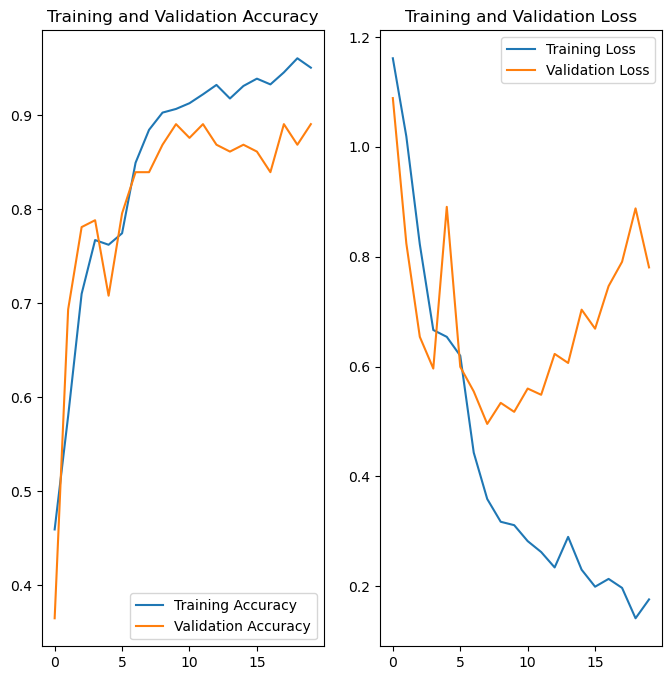

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

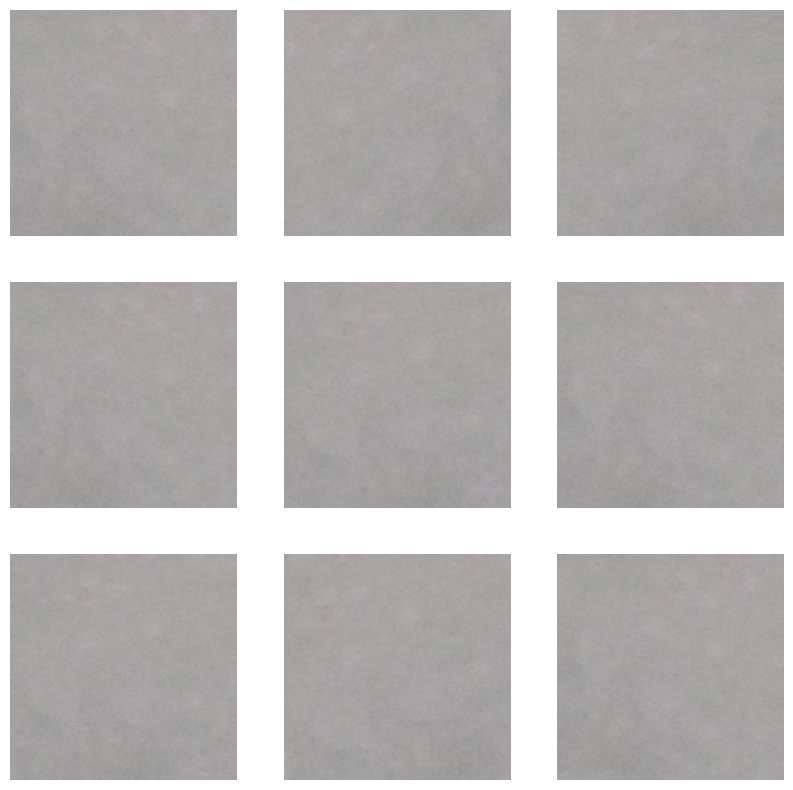

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [20]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
57/57 [==============================] - 39s 624ms/step - loss: 1.1980 - accuracy: 0.4667 - val_loss: 1.0891 - val_accuracy: 0.5328
Epoch 2/25
57/57 [==============================] - 35s 612ms/step - loss: 1.0172 - accuracy: 0.5867 - val_loss: 0.8306 - val_accuracy: 0.7445
Epoch 3/25
57/57 [==============================] - 40s 705ms/step - loss: 0.8603 - accuracy: 0.7006 - val_loss: 0.9803 - val_accuracy: 0.7372
Epoch 4/25
57/57 [==============================] - 36s 623ms/step - loss: 0.7458 - accuracy: 0.7228 - val_loss: 0.6359 - val_accuracy: 0.7956
Epoch 5/25
57/57 [==============================] - 37s 648ms/step - loss: 0.7672 - accuracy: 0.7150 - val_loss: 0.8140 - val_accuracy: 0.7664
Epoch 6/25
57/57 [==============================] - 39s 673ms/step - loss: 0.7042 - accuracy: 0.7394 - val_loss: 0.6260 - val_accuracy: 0.7883
Epoch 7/25
57/57 [==============================] - 43s 759ms/step - loss: 0.7175 - accuracy: 0.7483 - val_loss: 0.6632 - val_accuracy: 0.7737

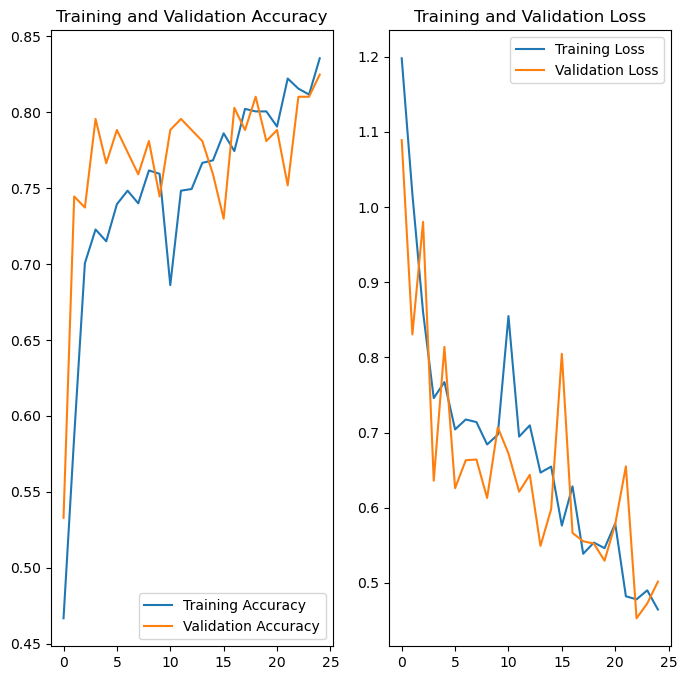

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.save("marbleModel.h5")

In [27]:
from tensorflow.keras.models import load_model
marbleModel=load_model('marbleModel.h5')
img = tf.keras.utils.load_img(
    'test_resim/mermer3.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = marbleModel.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 172ms/step
This image most likely belongs to joint with a 97.81 percent confidence.
